In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv('Rx_Prior_Auth_Data.csv')

In [3]:
df.head()

,PRIOR_AUTH_NUM,PRIOR_AUTH_TYPE,STATUS,AUTO_DENIED_FLAG,PA_CREATED_DATE,PA_CREATED_DATE_ONLY,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,ACCOUNT_ID,...,FORMULARY_STATUS,ICD_CODE,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,DRUG_UOM,DRUG_PACKAGE_SIZE,DRUG_PACKAGE_QTY,TOTAL_DRUG_PACKAGE_QTY
0,APP-465287,PAReqd,RESOLVED-OVERTURNED,N,2017-03-01-02.56.13,3/1/17,3/16/43,ZOLPIDEM TAB 10MG,MPDOVA,M11816OEB12809,...,Y,0,000-INSOMNIA,A,10.0,AMERHEALTH,MG,100,1,100
1,APP-465220,Nonformularyexception,RESOLVED-OVERTURNED,N,2017-03-01-00.33.24,3/1/17,6/28/48,LANSOPRAZOLE CAP 30MG DR,MPDOVA,M0C138HCFAZ6,...,N,0000|K29.70,0000-GERD|K29.70-GASTRITIS UNSPECIFIED WITHOUT...,A,30.0,BLUE POINT,MG,90,1,90
2,APP-465239,PAReqd,RESOLVED-OVERTURNED,N,2017-03-01-00.58.59,3/1/17,12/1/43,LETAIRIS TAB 10MG,PDPIND,P0102000000000,...,Y,0,0000-PULMONARY ARTERIAL HYPERTENSION(PAH),I,10.0,GILEAD SCI,MG,10,1,10
3,APP-465231,Nonformularyexception,RESOLVED-OVERTURNED,N,2017-03-01-00.48.40,3/1/17,12/27/47,VELTASSA POW 8.4GM,MPDOVA,M0D012HCFAJ6,...,N,N18.3|E87.5,N18.3-CHRONIC KIDNEY DISEASE STAGE 3 MODERATE|...,A,8.4,RELYPSA,GM,1,1,1
4,APP-465223,Nonformularyexception,RESOLVED-OVERTURNED,N,2017-03-01-00.34.40,3/1/17,9/22/67,LUNESTA TAB 3MG,PDPIND,P0101000000000,...,N,000|B18.2,000-INSOMNIA|B18.2-CHRONIC VIRAL HEPATITIS C,A,3.0,SUNOVION,MG,100,1,100


In [4]:
df.shape

(564881, 28)

In [94]:
df1=df.drop(['PRIOR_AUTH_NUM','AUTO_DENIED_FLAG','PA_CREATED_DATE','PA_CREATED_DATE_ONLY','ACCOUNT_ID','DIRECTIONS_FOR_USE','DRUG_UOM','DRUG_PACKAGE_SIZE','DRUG_PACKAGE_QTY','EMPLOYER_GROUP_ID','DIAGNOSIS_COMMENTS','PLAN_CODE','STATE_CODE','ICD_CODE'], axis=1)

In [95]:
df1.head()

,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,TOTAL_DRUG_PACKAGE_QTY
0,PAReqd,RESOLVED-OVERTURNED,3/16/43,ZOLPIDEM TAB 10MG,MPDOVA,F,ZOLPIDEM TARTRATE,N,Y,000-INSOMNIA,A,10.0,AMERHEALTH,100
1,Nonformularyexception,RESOLVED-OVERTURNED,6/28/48,LANSOPRAZOLE CAP 30MG DR,MPDOVA,F,LANSOPRAZOLE,N,N,0000-GERD|K29.70-GASTRITIS UNSPECIFIED WITHOUT...,A,30.0,BLUE POINT,90
2,PAReqd,RESOLVED-OVERTURNED,12/1/43,LETAIRIS TAB 10MG,PDPIND,F,LETAIRIS,N,Y,0000-PULMONARY ARTERIAL HYPERTENSION(PAH),I,10.0,GILEAD SCI,10
3,Nonformularyexception,RESOLVED-OVERTURNED,12/27/47,VELTASSA POW 8.4GM,MPDOVA,F,VELTASSA,N,N,N18.3-CHRONIC KIDNEY DISEASE STAGE 3 MODERATE|...,A,8.4,RELYPSA,1
4,Nonformularyexception,RESOLVED-OVERTURNED,9/22/67,LUNESTA TAB 3MG,PDPIND,F,LUNESTA,N,N,000-INSOMNIA|B18.2-CHRONIC VIRAL HEPATITIS C,A,3.0,SUNOVION,100


In [96]:
df1.shape

(564881, 14)

In [97]:
df1.dropna(inplace=True)

In [98]:
df1.shape

(515912, 14)

In [99]:
df1=pd.concat([df1[df1['STATUS']=='RESOLVED-DENIED'], df1[df1['STATUS']=='RESOLVED-APPROVED']])

In [100]:
df1.shape

(483787, 14)

In [101]:
print(len(df1['DRUG_MANUFACTURER_NAME'].value_counts()))
print(len(df1['DRUG_LABEL_NAME'].value_counts()))
print(len(df1['PRIOR_AUTH_TYPE'].value_counts()))
print(len(df1['CARRIER_ID'].value_counts()))
print(len(df1['BRAND_NAME'].value_counts()))
print(len(df1['ICD_DESCRIPTION'].value_counts()))

728
6940
22
414
3941
77781


removing rare labels in each category

In [102]:
df1=df1.groupby('DRUG_LABEL_NAME').filter(lambda x:len(x)>100)
df1=df1.groupby('DRUG_MANUFACTURER_NAME').filter(lambda x:len(x)>10)
df1=df1.groupby('CARRIER_ID').filter(lambda x:len(x)>10)
df1=df1.groupby('BRAND_NAME').filter(lambda x:len(x)>150)
df1=df1.groupby('ICD_DESCRIPTION').filter(lambda x:len(x)>20)

In [103]:
print(len(df1['DRUG_MANUFACTURER_NAME'].value_counts()))
print(len(df1['DRUG_LABEL_NAME'].value_counts()))
print(len(df1['PRIOR_AUTH_TYPE'].value_counts()))
print(len(df1['CARRIER_ID'].value_counts()))
print(len(df1['BRAND_NAME'].value_counts()))
print(len(df1['ICD_DESCRIPTION'].value_counts()))

206
735
20
296
425
1238


In [104]:
df1.shape

(291660, 14)

In [105]:
df1.head()

,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,TOTAL_DRUG_PACKAGE_QTY
16,Nonformularyexception,RESOLVED-DENIED,6/29/77,JANUVIA TAB 100MG,PDPIND,M,JANUVIA,N,N,000-TYPE 2 DIABETES MELLITUS,A,100.0,MERCKSHARP,1
25,PAReqd,RESOLVED-DENIED,4/14/49,TRETINOIN CRE 0.1%,MPDOVA,F,TRETINOIN,N,Y,L57.0-ACTINIC KERATOSIS,I,0.1,ROUSES PNT,45
30,MedNec,RESOLVED-DENIED,7/15/85,DICLEGIS TAB 10-10MG,UHCOXFD01,F,DICLEGIS,N,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100
37,PAReqd,RESOLVED-DENIED,5/8/42,LIDOCAINE PAD 5%,PDPIND,F,LIDOCAINE,N,Y,M54.5-LOW BACK PAIN,A,5.0,ACTAVIS PH,30
39,MedNec,RESOLVED-DENIED,11/2/81,DICLEGIS TAB 10-10MG,UHCACIS01,F,DICLEGIS,Y,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100


In [106]:
df1.reset_index(drop=True, inplace=True)

In [107]:
df1.head()

,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,TOTAL_DRUG_PACKAGE_QTY
0,Nonformularyexception,RESOLVED-DENIED,6/29/77,JANUVIA TAB 100MG,PDPIND,M,JANUVIA,N,N,000-TYPE 2 DIABETES MELLITUS,A,100.0,MERCKSHARP,1
1,PAReqd,RESOLVED-DENIED,4/14/49,TRETINOIN CRE 0.1%,MPDOVA,F,TRETINOIN,N,Y,L57.0-ACTINIC KERATOSIS,I,0.1,ROUSES PNT,45
2,MedNec,RESOLVED-DENIED,7/15/85,DICLEGIS TAB 10-10MG,UHCOXFD01,F,DICLEGIS,N,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100
3,PAReqd,RESOLVED-DENIED,5/8/42,LIDOCAINE PAD 5%,PDPIND,F,LIDOCAINE,N,Y,M54.5-LOW BACK PAIN,A,5.0,ACTAVIS PH,30
4,MedNec,RESOLVED-DENIED,11/2/81,DICLEGIS TAB 10-10MG,UHCACIS01,F,DICLEGIS,Y,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100


In [108]:
dob=pd.to_datetime(df1['DATE_OF_BIRTH'],format='%m/%d/%y').dt.year
today=pd.to_datetime('today').year
df1['DATE_OF_BIRTH']=today-dob

In [109]:
df1['DATE_OF_BIRTH'][df1['DATE_OF_BIRTH']<0]=100+df1['DATE_OF_BIRTH']
df1.head()

/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,TOTAL_DRUG_PACKAGE_QTY
0,Nonformularyexception,RESOLVED-DENIED,42,JANUVIA TAB 100MG,PDPIND,M,JANUVIA,N,N,000-TYPE 2 DIABETES MELLITUS,A,100.0,MERCKSHARP,1
1,PAReqd,RESOLVED-DENIED,70,TRETINOIN CRE 0.1%,MPDOVA,F,TRETINOIN,N,Y,L57.0-ACTINIC KERATOSIS,I,0.1,ROUSES PNT,45
2,MedNec,RESOLVED-DENIED,34,DICLEGIS TAB 10-10MG,UHCOXFD01,F,DICLEGIS,N,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100
3,PAReqd,RESOLVED-DENIED,77,LIDOCAINE PAD 5%,PDPIND,F,LIDOCAINE,N,Y,M54.5-LOW BACK PAIN,A,5.0,ACTAVIS PH,30
4,MedNec,RESOLVED-DENIED,38,DICLEGIS TAB 10-10MG,UHCACIS01,F,DICLEGIS,Y,Y,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,A,0.0,DUCHESNAY,100


In [110]:
# label encoding on STATUS, GENDER_CODE, HIGH_PRIORITY_FLAG, FORMULARY_STATUS, DRUG_STATUS_CODE
le=LabelEncoder()
col=['STATUS', 'GENDER_CODE', 'HIGH_PRIORITY_FLAG', 'FORMULARY_STATUS', 'DRUG_STATUS_CODE']
for c in col:
    df1[c]=le.fit_transform(df1[c])
#denied status is 1, accepted =0

In [111]:
df1.head()

,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,DRUG_STATUS_CODE,DRUG_STRENGTH,DRUG_MANUFACTURER_NAME,TOTAL_DRUG_PACKAGE_QTY
0,Nonformularyexception,1,42,JANUVIA TAB 100MG,PDPIND,1,JANUVIA,0,1,000-TYPE 2 DIABETES MELLITUS,1,100.0,MERCKSHARP,1
1,PAReqd,1,70,TRETINOIN CRE 0.1%,MPDOVA,0,TRETINOIN,0,2,L57.0-ACTINIC KERATOSIS,2,0.1,ROUSES PNT,45
2,MedNec,1,34,DICLEGIS TAB 10-10MG,UHCOXFD01,0,DICLEGIS,0,2,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,1,0.0,DUCHESNAY,100
3,PAReqd,1,77,LIDOCAINE PAD 5%,PDPIND,0,LIDOCAINE,0,2,M54.5-LOW BACK PAIN,1,5.0,ACTAVIS PH,30
4,MedNec,1,38,DICLEGIS TAB 10-10MG,UHCACIS01,0,DICLEGIS,1,2,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,1,0.0,DUCHESNAY,100


In [112]:
df1.shape

(291660, 14)

In [130]:
fh = FeatureHasher(n_features=40, input_type='string')
hashed_features = fh.fit_transform(df1['DRUG_MANUFACTURER_NAME'])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df1,hashed_features], axis=1)
                                       
fh = FeatureHasher(n_features=70, input_type='string')
hashed_features = fh.fit_transform(df1['DRUG_LABEL_NAME'])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df2,hashed_features], axis=1)
                                       
fh = FeatureHasher(n_features=5, input_type='string')
hashed_features = fh.fit_transform(df1['PRIOR_AUTH_TYPE'])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df2,hashed_features], axis=1)
 
fh = FeatureHasher(n_features=10, input_type='string')
hashed_features = fh.fit_transform(df1['CARRIER_ID' ])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df2,hashed_features], axis=1)  
                                    
fh = FeatureHasher(n_features=50, input_type='string')
hashed_features = fh.fit_transform(df1['BRAND_NAME'])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df2,hashed_features], axis=1)      
                                       
fh = FeatureHasher(n_features=100, input_type='string')
hashed_features = fh.fit_transform(df1['ICD_DESCRIPTION'])
hashed_features = pd.DataFrame(hashed_features.toarray())
df2=pd.concat([df2,hashed_features], axis=1)          

# 206
# 735
# 20
# 74
# 346
# 1238

In [131]:
df2.shape

(291660, 289)

In [132]:
df2.head()

,PRIOR_AUTH_TYPE,STATUS,DATE_OF_BIRTH,DRUG_LABEL_NAME,CARRIER_ID,GENDER_CODE,BRAND_NAME,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,ICD_DESCRIPTION,...,90,91,92,93,94,95,96,97,98,99
0,Nonformularyexception,1,42,JANUVIA TAB 100MG,PDPIND,1,JANUVIA,0,1,000-TYPE 2 DIABETES MELLITUS,...,0,0,0,0,0,0,0,0,0,0
1,PAReqd,1,70,TRETINOIN CRE 0.1%,MPDOVA,0,TRETINOIN,0,2,L57.0-ACTINIC KERATOSIS,...,0,0,0,0,0,0,0,0,0,0
2,MedNec,1,34,DICLEGIS TAB 10-10MG,UHCOXFD01,0,DICLEGIS,0,2,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,...,0,0,0,0,0,0,0,0,0,0
3,PAReqd,1,77,LIDOCAINE PAD 5%,PDPIND,0,LIDOCAINE,0,2,M54.5-LOW BACK PAIN,...,0,0,0,0,0,0,0,0,0,0
4,MedNec,1,38,DICLEGIS TAB 10-10MG,UHCACIS01,0,DICLEGIS,1,2,O21.9-VOMITING OF PREGNANCY UNSPECIFIED,...,0,0,0,0,0,0,0,0,0,0


In [133]:
df3=df2.drop(['DRUG_MANUFACTURER_NAME','DRUG_LABEL_NAME','PRIOR_AUTH_TYPE','CARRIER_ID','BRAND_NAME','ICD_DESCRIPTION'], axis=1)

In [134]:
df3.head()

,STATUS,DATE_OF_BIRTH,GENDER_CODE,HIGH_PRIORITY_FLAG,FORMULARY_STATUS,DRUG_STATUS_CODE,DRUG_STRENGTH,TOTAL_DRUG_PACKAGE_QTY,0,1,...,90,91,92,93,94,95,96,97,98,99
0,1,42,1,0,1,1,100.0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
1,1,70,0,0,2,2,0.1,45,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,34,0,0,2,1,0.0,100,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,77,0,0,2,1,5.0,30,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,1,38,0,1,2,1,0.0,100,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
def scaling(x):
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x)
    # Apply transform to both the training set and the test set.
    x_scale= pd.DataFrame(scaler.transform(x))
    return x_scale

lets do resampling of data points to get equal data in all classes

In [136]:
print(df3['STATUS'].value_counts())
count_0, count_1=df3['STATUS'].value_counts()
status_0=df3[df3['STATUS']==0]
status_1=df3[df3['STATUS']==1]

0    184484
1    107176
Name: STATUS, dtype: int64


In [137]:
df_over=status_1.sample(count_0, replace=True)
df_over=pd.concat([df_over,status_0], axis=0)
df_over['STATUS'].value_counts()

1    184484
0    184484
Name: STATUS, dtype: int64

In [138]:
y=df_over['STATUS']
x=df_over.drop('STATUS', axis=1)

In [139]:
x_scale=scaling(x)

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [140]:
train_x, test_x, train_y, test_y= train_test_split(x_scale,y,test_size=0.33)

deep neural network

In [179]:
from keras import Sequential
from keras.layers import Dense

#input is 282 dimensional
def model():
    model=Sequential()
    #first hidden layer
    model.add(Dense(128, activation='relu',input_dim=282))
    #second hidden layer
    model.add(Dense(64, activation='relu'))
    #third hidden layer
    model.add(Dense(32, activation='relu'))
    #output layer
    model.add(Dense(1, activation='sigmoid'))
    return model

nn=model()
#Compiling the neural network
nn.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['acc'])
              
#Fitting the data to the training dataset
history=nn.fit(train_x, train_y, batch_size=20, epochs=20)


Epoch 1/20
247208/247208 [==============================] - 26s 106us/step - loss: 0.4391 - acc: 0.7876
Epoch 2/20
247208/247208 [==============================] - 26s 106us/step - loss: 0.4022 - acc: 0.8092
Epoch 3/20
247208/247208 [==============================] - 26s 106us/step - loss: 0.3889 - acc: 0.8173
Epoch 4/20
247208/247208 [==============================] - 28s 113us/step - loss: 0.3800 - acc: 0.8211
Epoch 5/20
247208/247208 [==============================] - 28s 114us/step - loss: 0.3729 - acc: 0.8259
Epoch 6/20
247208/247208 [==============================] - 28s 112us/step - loss: 0.3670 - acc: 0.8286
Epoch 7/20
247208/247208 [==============================] - 28s 113us/step - loss: 0.3622 - acc: 0.8308
Epoch 8/20
247208/247208 [==============================] - 28s 113us/step - loss: 0.3574 - acc: 0.8345
Epoch 9/20
247208/247208 [==============================] - 28s 115us/step - loss: 0.3537 - acc: 0.8355
Epoch 10/20
247208/247208 [==============================] - 29s

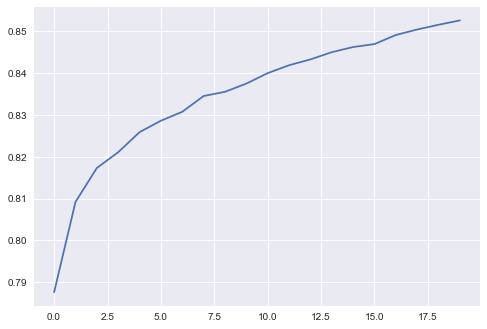

In [180]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [181]:
nn.evaluate(train_x, train_y)

247208/247208 [==============================] - 7s 26us/step


[0.30789937397557277, 0.8589325588168668]

In [182]:
nn.evaluate(test_x, test_y)

121760/121760 [==============================] - 3s 23us/step


[0.3860918287594121, 0.8305190538764783]

In [183]:
pred_y=nn.predict(test_x)
pred_y =(pred_y>0.5)

In [184]:
print(confusion_matrix(test_y, pred_y))
print("auc:" ,roc_auc_score(test_y, pred_y))

[[48774 12082]
 [ 8554 52350]]
auc: 0.8305076050526305


[0]	validation_0-auc:0.718069	validation_1-auc:0.717192
[1]	validation_0-auc:0.73172	validation_1-auc:0.731685
[2]	validation_0-auc:0.732506	validation_1-auc:0.732765
[3]	validation_0-auc:0.742459	validation_1-auc:0.742067
[4]	validation_0-auc:0.760096	validation_1-auc:0.759748
[5]	validation_0-auc:0.760097	validation_1-auc:0.759749
[6]	validation_0-auc:0.760038	validation_1-auc:0.759691
[7]	validation_0-auc:0.760046	validation_1-auc:0.759674
[8]	validation_0-auc:0.782934	validation_1-auc:0.783284
[9]	validation_0-auc:0.790627	validation_1-auc:0.791269
[10]	validation_0-auc:0.790435	validation_1-auc:0.791164
[11]	validation_0-auc:0.79064	validation_1-auc:0.79147
[12]	validation_0-auc:0.791171	validation_1-auc:0.792222
[13]	validation_0-auc:0.795778	validation_1-auc:0.796934
[14]	validation_0-auc:0.796819	validation_1-auc:0.797769
[15]	validation_0-auc:0.796233	validation_1-auc:0.797236
[16]	validation_0-auc:0.797418	validation_1-auc:0.798351
[17]	validation_0-auc:0.798163	validation_1-

[144]	validation_0-auc:0.858142	validation_1-auc:0.858407
[145]	validation_0-auc:0.85841	validation_1-auc:0.858676
[146]	validation_0-auc:0.85846	validation_1-auc:0.858725
[147]	validation_0-auc:0.858544	validation_1-auc:0.858817
[148]	validation_0-auc:0.858629	validation_1-auc:0.858894
[149]	validation_0-auc:0.858697	validation_1-auc:0.85898
[150]	validation_0-auc:0.858678	validation_1-auc:0.858956
[151]	validation_0-auc:0.858938	validation_1-auc:0.85923
[152]	validation_0-auc:0.859195	validation_1-auc:0.859522
[153]	validation_0-auc:0.859307	validation_1-auc:0.859639
[154]	validation_0-auc:0.859526	validation_1-auc:0.859845
[155]	validation_0-auc:0.85966	validation_1-auc:0.859969
[156]	validation_0-auc:0.859738	validation_1-auc:0.860043
[157]	validation_0-auc:0.859877	validation_1-auc:0.860201
[158]	validation_0-auc:0.859969	validation_1-auc:0.860283
[159]	validation_0-auc:0.860231	validation_1-auc:0.860563
[160]	validation_0-auc:0.860429	validation_1-auc:0.860761
[161]	validation_0-

[286]	validation_0-auc:0.87302	validation_1-auc:0.87302
[287]	validation_0-auc:0.873062	validation_1-auc:0.873053
[288]	validation_0-auc:0.873084	validation_1-auc:0.873072
[289]	validation_0-auc:0.873113	validation_1-auc:0.873106
[290]	validation_0-auc:0.873168	validation_1-auc:0.873155
[291]	validation_0-auc:0.873227	validation_1-auc:0.873199
[292]	validation_0-auc:0.873282	validation_1-auc:0.873234
[293]	validation_0-auc:0.873349	validation_1-auc:0.873301
[294]	validation_0-auc:0.873397	validation_1-auc:0.873354
[295]	validation_0-auc:0.873479	validation_1-auc:0.873435
[296]	validation_0-auc:0.873654	validation_1-auc:0.873597
[297]	validation_0-auc:0.873769	validation_1-auc:0.873743
[298]	validation_0-auc:0.87378	validation_1-auc:0.87374
[299]	validation_0-auc:0.873793	validation_1-auc:0.87375
[300]	validation_0-auc:0.87386	validation_1-auc:0.873803
[301]	validation_0-auc:0.87388	validation_1-auc:0.873825
[302]	validation_0-auc:0.873925	validation_1-auc:0.873866
[303]	validation_0-au

[429]	validation_0-auc:0.880304	validation_1-auc:0.879482
[430]	validation_0-auc:0.880343	validation_1-auc:0.879512
[431]	validation_0-auc:0.880365	validation_1-auc:0.879529
[432]	validation_0-auc:0.880376	validation_1-auc:0.879535
[433]	validation_0-auc:0.880431	validation_1-auc:0.879596
[434]	validation_0-auc:0.880464	validation_1-auc:0.879612
[435]	validation_0-auc:0.880559	validation_1-auc:0.87971
[436]	validation_0-auc:0.880601	validation_1-auc:0.879744
[437]	validation_0-auc:0.880627	validation_1-auc:0.879757
[438]	validation_0-auc:0.880672	validation_1-auc:0.879792
[439]	validation_0-auc:0.88069	validation_1-auc:0.879799
[440]	validation_0-auc:0.880715	validation_1-auc:0.879821
[441]	validation_0-auc:0.880721	validation_1-auc:0.879825
[442]	validation_0-auc:0.880761	validation_1-auc:0.879869
[443]	validation_0-auc:0.880806	validation_1-auc:0.879921
[444]	validation_0-auc:0.880818	validation_1-auc:0.879934
[445]	validation_0-auc:0.880855	validation_1-auc:0.879959
[446]	validation

[571]	validation_0-auc:0.885289	validation_1-auc:0.883884
[572]	validation_0-auc:0.885299	validation_1-auc:0.883891
[573]	validation_0-auc:0.885304	validation_1-auc:0.883892
[574]	validation_0-auc:0.885339	validation_1-auc:0.883916
[575]	validation_0-auc:0.885354	validation_1-auc:0.883929
[576]	validation_0-auc:0.885365	validation_1-auc:0.883938
[577]	validation_0-auc:0.885416	validation_1-auc:0.883989
[578]	validation_0-auc:0.885438	validation_1-auc:0.884011
[579]	validation_0-auc:0.885459	validation_1-auc:0.88403
[580]	validation_0-auc:0.885496	validation_1-auc:0.884054
[581]	validation_0-auc:0.885561	validation_1-auc:0.884122
[582]	validation_0-auc:0.885579	validation_1-auc:0.884129
[583]	validation_0-auc:0.88558	validation_1-auc:0.884128
[584]	validation_0-auc:0.885594	validation_1-auc:0.884134
[585]	validation_0-auc:0.88565	validation_1-auc:0.884178
[586]	validation_0-auc:0.885745	validation_1-auc:0.884264
[587]	validation_0-auc:0.885778	validation_1-auc:0.884283
[588]	validation_

[713]	validation_0-auc:0.889226	validation_1-auc:0.8873
[714]	validation_0-auc:0.88923	validation_1-auc:0.887306
[715]	validation_0-auc:0.889239	validation_1-auc:0.88731
[716]	validation_0-auc:0.889254	validation_1-auc:0.88732
[717]	validation_0-auc:0.889287	validation_1-auc:0.887347
[718]	validation_0-auc:0.889311	validation_1-auc:0.887369
[719]	validation_0-auc:0.889317	validation_1-auc:0.88737
[720]	validation_0-auc:0.889334	validation_1-auc:0.887383
[721]	validation_0-auc:0.889344	validation_1-auc:0.887389
[722]	validation_0-auc:0.889354	validation_1-auc:0.887398
[723]	validation_0-auc:0.889376	validation_1-auc:0.887425
[724]	validation_0-auc:0.889406	validation_1-auc:0.887448
[725]	validation_0-auc:0.889431	validation_1-auc:0.88747
[726]	validation_0-auc:0.889441	validation_1-auc:0.887472
[727]	validation_0-auc:0.889443	validation_1-auc:0.887474
[728]	validation_0-auc:0.889451	validation_1-auc:0.887478
[729]	validation_0-auc:0.889463	validation_1-auc:0.887486
[730]	validation_0-au

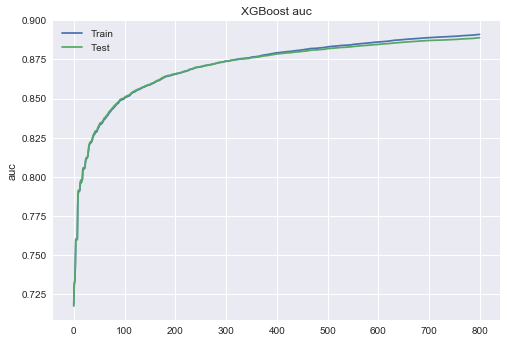

In [185]:
model=XGBClassifier(n_jobs=-1, n_estimators=800)
eval_set = [(train_x, train_y), (test_x, test_y)]
model.fit(train_x, train_y, eval_metric='auc' , eval_set=eval_set)

results=model.evals_result()

epochs=len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# fig, ax = plt.subplots()
plt.plot(x_axis, results['validation_0']['auc'], label='Train')
plt.plot(x_axis, results['validation_1']['auc'], label='Test')
plt.legend()
plt.ylabel('auc')
plt.title('XGBoost auc')
plt.show()

In [186]:
xgb=XGBClassifier(n_estimators=800)
xgb.fit(train_x,train_y)
pred_y=xgb.predict(test_x)
print('acc: ',xgb.score(test_x, test_y))
print('auc: ',roc_auc_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

acc:  0.8039996714848883
auc:  0.8039856963980112
[[46770 14086]
 [ 9779 51125]]


In [187]:
rf=RandomForestClassifier(n_estimators=1400)
rf.fit(train_x, train_y)
pred_y=rf.predict(test_x)
print('acc: ',rf.score(test_x, test_y))
print('auc: ',roc_auc_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

acc:  0.8676248357424442
auc:  0.8676095074860964
[[50433 10423]
 [ 5695 55209]]
